# PHYS642 : Radiative processes in Astrophysics
## Homework 1 : The Grey Atmosphere

We calculate the spectrum of a grey atmosphere (frequency-independent opacity) with
the lambda iteration method, and check its validity with the Feautrier method.

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expn,exp1
from scipy.integrate import quad,trapz
from scipy.interpolate import interp1d
from numpy import exp,pi

# chandra.py goes through the calculation of Chandrasekhar's Radiative Transfer Chapter 3
# for the analytical solution to the grey atmosphere
# (there are errors in Ch.3 Table 8)
import chandra 

## Lambda iteration method

The mean intensity of the grey atmosphere obeys the equation
$$J(\tau)=\Lambda_\tau[J]\,,$$

where the $\Lambda$ operator is defined as
$$\Lambda_c[f(x)]=\frac{1}{2}\int_0^\infty f(x)E_1(|x-c|)dx\,.$$

This suggests the use of an iterative method $J_{i+1}(\tau)=\Lambda_\tau[J_i]$, until convergence.


Our first try for the mean intensity is the Eddington approximation
$$J_0(\tau)=\frac{3F}{4\pi}(\tau+2/3)\,.$$

To compare the results of the following iterations, we will write $J$ as a sum of a linear and non-linear term in $\tau$:
$$J_i(\tau)=\frac{3F}{4\pi}(\tau+q_i(\tau))\,.$$

We have $q_0(\tau)=2/3$. It can also be shown analytically that
$$q_1(\tau)=\frac{2}{3}-\frac{1}{3}E_2(\tau)+\frac{1}{2}E_3(\tau)\,.$$
We will use this as a sanity check for our lambda operator computation.

Finally, we will use Chandrasekhar's analytical solution to the grey atmosphere in the form $q(\tau)=Q+\sum_i l_i\exp(-k_i\tau)$ to check our results.

In [2]:
# I use scipy quad on an interpolated J, but many other integration methods are possible

def Lambda(tau,f): 
    
    integrand = lambda t : f(t)*exp1(abs(t-tau))
    
    # exp1(x) is singular at x=0.  This is not a problem analytically but numerically could cause some issues.
    # One way to deal with it is to integrate left and right of the singularity (t=[0,tau-eps] and t=[tau+eps,inf])
    # where eps is a tiny number, then add the two sides
    eps = 1e-10
    if tau-eps<0:
        int_left=0
    else:
        int_left,_  = quad(integrand,0,tau-eps)             
    int_right,_ = quad(integrand,tau+eps,np.inf)
    
    return 0.5 * (int_left+int_right)
    
def UpdateJ(Tau,Jfunc):  
    # Takes previous result of J (must be a callable function) and applies lambda operation to every point
    Jnew = []
    for tau in Tau:
        Jnew.append(Lambda(tau,Jfunc))
    return np.array(Jnew)

# We will calculate on an optical depth array going from tau=0 to 10 in 50 points
Tau = np.linspace(0,10,50)

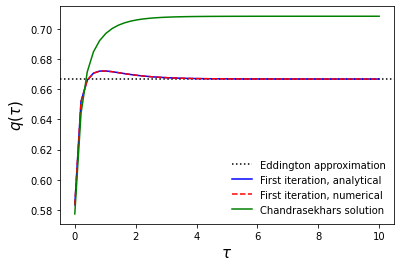

In [3]:
# Try first iteration

# Note that the overall constant 3F/4pi is arbitrary. We set it to 1 for simplicity
J0func = lambda t : t + 2/3   # J=3F/4pi(tau+q)
J1 = UpdateJ(Tau,J0func)
q1 = J1-Tau


# Analytical forms
q1func = lambda t : 2/3 - 1/3*expn(2,t) + 1/2*expn(3,t) 

def qChandra(tau):
    K,L,Q = chandra.coefficients(5) # n=5
    return Q + sum([l*np.exp(-k*tau) for (l,k) in zip(L,K)])


# Plot first two iterations and Chandrasekhar's solution
plt.figure()
plt.axhline(2/3,color='k',ls=':',label='Eddington approximation')
plt.plot(Tau,q1func(Tau),'b',label='First iteration, analytical')
plt.plot(Tau,q1,'r--',label='First iteration, numerical')
plt.plot(Tau,qChandra(Tau),'g',label=r'Chandrasekhar''s solution')
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$q(\tau)$',fontsize=15)
plt.legend(frameon=False)
# plt.ylim([2/3-0.001,2/3+0.001])
plt.show()

Our first iteration seems to work, so we shall proceed with the algorithm.  To speed things up, we will force $q(\tau)$ to be monotically increasing at every iteration, since we know that the analytical solution is so.  We do this by setting every value past the maximum of the curve to be equal to that maximum.  We stop iterating once the difference between consecutive iterations has a  norm lower than the tolerance, which we set to $10^{-5}$.

In [4]:
def MakeMonotonic(y):  # flattens the part of the array that breaks monotonicity (according to the peak max)
    i = np.argmax(y)
    y[i:] = y[i]
    return y

# Store the values of q at each iteration for plotting later
qs = []
Jfunc = J0func
i,nitermax,diff = 0,1e4,1
while i<=nitermax and diff>1e-5:
    
    i+=1
    
    # Apply Lambda
    J = UpdateJ(Tau,Jfunc)
    q = J-Tau
    
    # Run with monotonic hack (comment line below to run without)
    q = MakeMonotonic(q)  

    # Interpolate q with a spline, with constant extrapolation (q(tau<0)=q(0) and q(tau>10)=q(10))
    qfunc = interp1d(Tau, q, kind='cubic', bounds_error=False, fill_value=(q[0],q[-1]))
    qs.append(np.array(qfunc(Tau))) 

    # Updated J that goes into next iteration
    Jfunc = lambda t : t + qfunc(t)
            
    if i>2:     diff = np.linalg.norm(qs[-1]-qs[-2])
    if i%25==0: print(f"iteration #{i}: diff = {diff:.3e}")

print(f"\nConverged in {i} iterations")

iteration #25: diff = 2.815e-03
iteration #50: diff = 9.904e-04
iteration #75: diff = 4.453e-04
iteration #100: diff = 2.323e-04
iteration #125: diff = 1.324e-04
iteration #150: diff = 8.064e-05
iteration #175: diff = 5.154e-05
iteration #200: diff = 3.448e-05
iteration #225: diff = 2.367e-05
iteration #250: diff = 1.678e-05
iteration #275: diff = 1.214e-05

Converged in 291 iterations


Let's have a look at some of the steps.

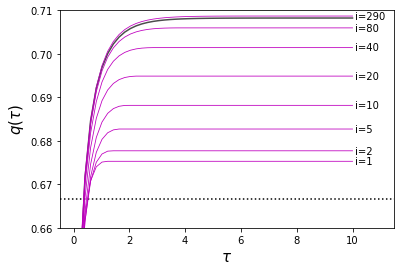

In [5]:
plt.figure()
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$q(\tau)$',fontsize=15)

plt.axhline(2/3,color='k',ls=':',label='Eddington approximation')
plt.plot(Tau,qChandra(Tau),'k-',alpha=0.7,lw=1.5)

iterations_to_plot = (1,2,5,10,20,40,80,len(qs)-1)
for i in iterations_to_plot:
    plt.plot(Tau,qs[i],'m',lw=0.8)
    plt.text(Tau[-1]+0.1,qs[i][-1],('i=%d'%i),va='center')

plt.xlim([-0.5,Tau[-1]+1.5])
plt.ylim([0.66,0.71])
plt.show()

There is a slight difference with Chandrasekhar's solution, perhaps there is room for further convergence. Anyway, the solution seems good enough to move on to calculating a spectrum.

The spectrum, written in terms of the flux $F_\nu$, is calculated as
$$F_\nu=2\pi\int_0^1\mu d\mu\int_0^\infty e^{-t/\mu}S_\nu(t)\frac{dt}{\mu}\,.$$

In LTE, we assume that the source function $S_\nu(\tau)$ is equal to the Planck function $B_\nu(T)$, where the temperature is a function of optical depth.  The temperature profile of the atmosphere is found from our $q(\tau)$ formulation with
$$B=\frac{\sigma T^4}{\pi}=S=J=\frac{3F}{4\pi}(\tau+q(\tau))\quad\Rightarrow\quad T^4=\frac{3}{4}T^4_\text{eff}(\tau+q(\tau))\,,$$

where $T_\text{eff}=(F/\sigma)^{1/4}$ is the effective blackbody temperature of the outgoing spectrum.

We re-write the flux integral in terms of $B_\nu$, and use the fact that it is isotropic:
\begin{align}
F_\nu&=2\pi\int_0^1\mu d\mu\int_0^\infty e^{-t/\mu}B_\nu(t)\frac{dt}{\mu}\\
&=2\pi\int_0^\infty B_\nu(t) dt\int_0^1 e^{-t/\mu}d\mu\\
&=2\pi\int_0^\infty B_\nu(t) dt\int_t^\infty t x^{-2} e^{-x}dx \qquad;\qquad (x=t/\mu)\\
&=2\pi\int_0^\infty B_\nu(t) E_2(t)dt
\end{align}

We can work in natural units $h=k_B=c=1$. We just need to have the proper Planck law normalization, $\int B_\nu d\nu=\sigma T^4/\pi$, for which we need to set $\sigma=2\pi^5/15$.

Normalized integrated flux for Edd, Grey, Planck:
1.0
1.0
1.0


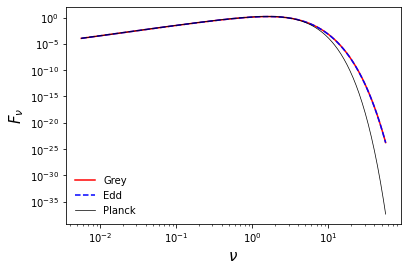

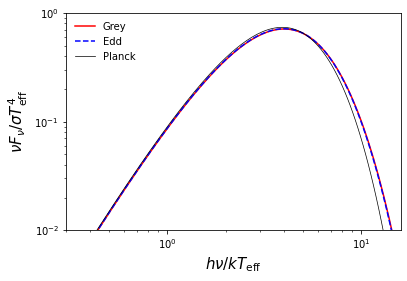

In [6]:
# Temperature profile of grey atmosphere for different approximations
sigmarad = 2*np.pi**5/15
Teff = (4*np.pi/3/sigmarad)**0.25  # recall 3F/4pi=1
Tprofile_Planck = lambda t : Teff
Tprofile_Edd    = lambda t : Teff * (0.75*(t+2/3))**0.25
Tprofile_Grey   = lambda t : Teff * (0.75*(t+qfunc(t)))**0.25    # Last 'qfunc' from while loop is still in memory

def Fnu(nu,Tprofile):
    
    def integrand(tau):
        T = Tprofile(tau) 
        Bnu = 2*nu**3/(exp(nu/T) - 1)  # Planck function (h=c=kB=1)
        return Bnu*expn(2,tau)
    
    y,_ = quad(integrand,0,np.inf)
    return 2*pi*y

# Which frequencies are relevant? The peak is at x=hnu/kT ~ 2.8 (Wien's law), so ~10^0 in x-space
x = np.logspace(-2,2,300)
Nu = Teff * x

# Do integral at every frequency
Fnu_Edd,Fnu_Grey,Fnu_Planck = [],[],[]
for nu in Nu:
    Fnu_Edd.append(Fnu(nu,Tprofile_Edd))
    Fnu_Grey.append(Fnu(nu,Tprofile_Grey))
    Fnu_Planck.append(Fnu(nu,Tprofile_Planck))
    
# Make sure we have the correct integrated flux
print("Normalized integrated flux for Edd, Grey, Planck:")
for Fnu in (Fnu_Edd,Fnu_Grey,Fnu_Planck):
    F = trapz(Fnu, x=Nu)
    F /= (4*np.pi/3) # normalize by F0
    print(round(F,2))

# Plot spectrum
plt.figure()
plt.loglog(Nu, Fnu_Grey,'r',label='Grey')
plt.loglog(Nu, Fnu_Edd,'b--',label='Edd')
plt.loglog(Nu, Fnu_Planck,'k',label='Planck',lw=0.7)
plt.xlabel(r'$\nu$',fontsize=15)
plt.ylabel(r'$F_\nu$',fontsize=15)
plt.legend(loc=3,frameon=False)

# Plot in dimensionless units
plt.figure()
plt.loglog(x, Nu*Fnu_Grey/(sigmarad*Teff**4),'r',label='Grey')
plt.loglog(x, Nu*Fnu_Edd/(sigmarad*Teff**4),'b--',label='Edd')
plt.loglog(x, Nu*Fnu_Planck/(sigmarad*Teff**4),'k',label='Planck',lw=0.7)
plt.xlabel(r'$h\nu/kT_{\rm eff}$',fontsize=15)
plt.ylabel(r'$\nu F_\nu/\sigma{T^4_{\rm eff}}$',fontsize=15)
plt.legend(loc=2,frameon=False)
plt.xlim([0.3,16])
plt.ylim([0.01,1])
plt.show()

The grey spectrum is slightly harder than the Planck spectrum, because it probes temperatures larger than $T_{\rm eff}$ at depth. Notice too that, as far as the spectrum goes, the Eddington approximaton does a very good job.

Another property of the atmosphere to look at is the limb darkening law, found by evaluating the intensity of the radiation at $\tau=0$ as a function of angle:

\begin{align}
I(\tau=0,\mu)=\int_0^\infty e^{-t/\mu}S(t)\frac{dt}{\mu}=\frac{3F}{4\pi}\int_0^\infty e^{-t/\mu}(t+q(t))\frac{dt}{\mu}
\end{align}

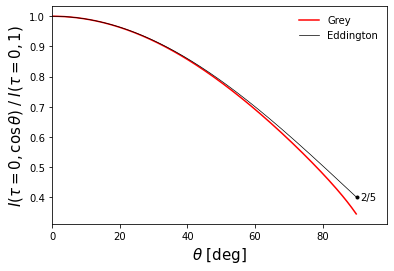

In [7]:
def I(mu,q):
    integrand = lambda t : np.exp(-t/mu)/mu * (t+q(t))
    y,_ = quad(integrand,0,np.inf)
    return y

deg = np.linspace(0,89.9,200)
Mu= np.cos(deg/180*pi)
I_Edd,I_Grey = [],[]
for mu in Mu:
    I_Edd.append(I(mu,q=lambda t:2/3))
    I_Grey.append(I(mu,q=qfunc))

plt.figure()
plt.plot(deg, np.array(I_Grey)/I_Grey[0],'r',label='Grey')
plt.plot(deg, np.array(I_Edd)/I_Edd[0],'k',label='Eddington',lw=0.7)
plt.plot([90],[2/5],'k.')
plt.text(91,2/5,'2/5',va='center')
plt.xlabel(r'$\theta$ [deg]',fontsize=15)
plt.ylabel(r'$I(\tau=0,\cos\theta)\;/\;I(\tau=0,1)$',fontsize=15)
plt.xlim([0,99])
plt.legend(frameon=False)
plt.show()

The limb darkening effect is slightly stronger for a grey atmosphere than for the Eddington approximation.

## Feautrier method

We can do the inverse problem where we start with the source function $S(\tau)$, and through the radiative transfer equations find the flux.  If the flux is a constant across all optical depths, then our choice of $S(\tau)$ is correct.  So let's check if the source function we found in the last section works.  

Separating the radiative transfer between forward-propagating and back-propagating radiation, $I(\mu)$ and $I(-\mu)$, we define the variables:
$$j(\mu)=\frac{1}{2}[I(\mu)+I(-\mu)] \quad\quad h(\mu)=\frac{1}{2}[I(\mu)-I(-\mu)]$$

Then, the radiative transfer equation can be written as two first-order and one second-order differential equations for $j$ and $h$:

$$
\begin{cases}
\mu\frac{dh}{d\tau}=-S+j \\ 
\mu\frac{dj}{d\tau}=h \\ 
\mu^2\frac{d^2j}{d\tau^2}=-S+j
\end{cases}
$$

We the third equation on a finite optical depth grid of $N$ points with equal spacing $\Delta\tau$.  If $i=1$ represents the first grid point, the second order differential equation gives, for $1<i<N$ : 
$$-z^2j_{i-1}+\left(1+2z^2\right)j_i-z^2j_{i+1}=S_i \,,$$
where $z\equiv\mu/\Delta\tau$.

We also need two boundary conditions.  At $\tau=0$, there is no ingoing radiation: ($I(-\mu)=0$) so $j=h$.  At $\tau\rightarrow\infty$, radiation is isotropic so $h=0$.  For $i=1$ and $i=N$, we Taylor expand $j$ to second order and use the derivatives of $j$ to obtain algebraic equations:
$$j_2\approx j_1+\frac{dj}{d\tau}\bigg\rvert_{\tau=0}\Delta\tau+\frac{1}{2}\frac{d^2j}{d\tau^2}\bigg\rvert_{\tau=0}\Delta\tau^2=j_1+j_1\frac{\Delta\tau}{\mu}+\frac{1}{2}\frac{(j_1-S_1)}{\mu^2}\Delta\tau^2$$
$$j_{N-1}\approx j_N-\frac{dj}{d\tau}\bigg\rvert_{\tau\rightarrow\infty}\Delta\tau+\frac{1}{2}\frac{d^2j}{d\tau^2}\bigg\rvert_{\tau\rightarrow\infty}\Delta\tau^2=j_N+\frac{1}{2}\frac{(j_N-S_N)}{\mu^2}\Delta\tau^2$$

Re-writing:
$$j_1\left(1+2z+2z^2\right)-2j_2z^2=S_1$$
$$-2j_{N-1}z^2+j_N\left(1+2z^2\right)=S_N$$

This sets up the equation $\mathbf{Aj}=\mathbf{S}$, where $A$ is a tridiagonal matrix with the first and last rows modified for boundary conditions. After solving, we can recover $h$ by differentiating $j$.

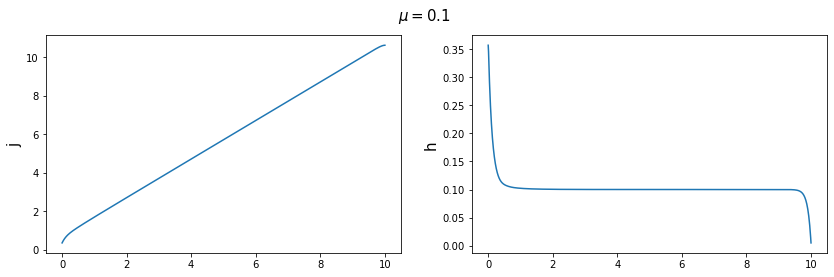

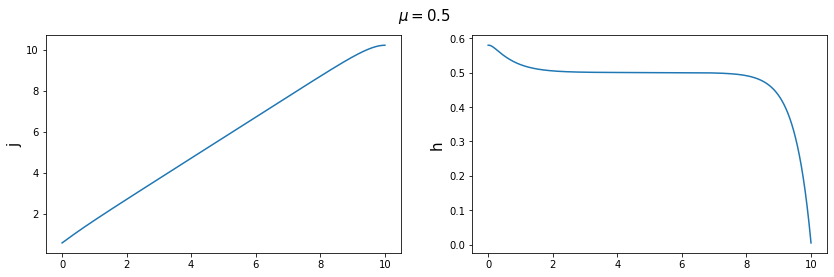

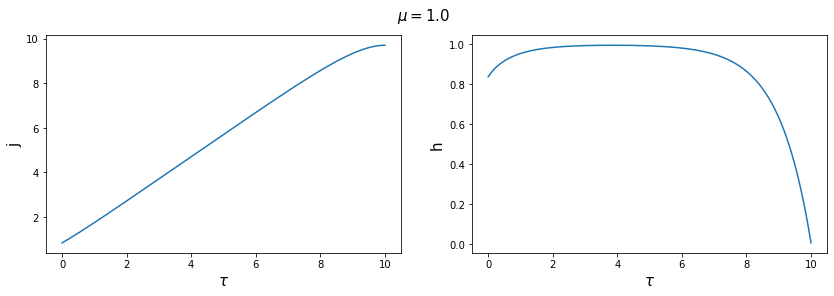

In [8]:
Tau=np.linspace(0,10,1000)
N,dtau = len(Tau),Tau[1]-Tau[0] # properties of optical depth grid

# We'll use the mean intensity found in the first part for the source function
S = Jfunc(Tau)

def Solve(mu):
    
    # Construct the Feautrier matrix then solve for j
    z = mu/dtau
    
    # The matrix is tri-diagonal
    bottom = [-z**2 for i in range(N-1)]
    top    = [-z**2 for i in range(N-1)]
    center = [(1+2*z**2) for i in range(N)]
    
    # tau=0 B.C.
    center[0] = 1+2*(z+z**2)
    top[0]    = -2*z**2
    
    # tau->inf B.C.
    center[-1] = 1+2*z**2
    bottom[-1] = -2*z**2
    
    A = np.zeros((N,N))
    A[0][:2] = [center[0],top[0]]        # first line
    A[-1][-2:] = [bottom[-1],center[-1]] # last line
    for i in range(1,N-1):               # all other lines
        A[i][i-1:i+2] = [bottom[i-1],center[i],top[i]]
    
    return np.linalg.solve(A,S)

def h_from_j(j,mu):
    h=[j[0]]
    h[1:] = mu * (j[1:]-j[:-1])/dtau
    return h
        
# Test for three values of mu
for mu in [0.1,0.5,1]:
    j = Solve(mu)
    h = h_from_j(j,mu)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,4))
    fig.suptitle(r'$\mu=%.1f$'%mu,fontsize=15,fontweight='bold')
    ax1.plot(Tau,j)
    ax2.plot(Tau,h)
    ax1.set_ylabel('j',fontsize=15)
    ax2.set_ylabel('h',fontsize=15)
ax1.set_xlabel(r'$\tau$',fontsize=15)
ax2.set_xlabel(r'$\tau$',fontsize=15)
plt.show()

These curves are smooth and obey the boundary conditions.  To recover the flux:
\begin{align}
F(\tau)&=2\pi\int_{-1}^1 \mu I(\tau,\mu)d\mu\\
&=2\pi\left(\int_{-1}^0\mu I(\tau,\mu)d\mu + \int_{0}^1\mu I(\tau,\mu)d\mu\right)\\
&=2\pi\left(\int_1^0 x I(\tau,-x)dx + \int_{0}^1\mu I(\tau,\mu)d\mu\right) \qquad;\qquad (x=-\mu)\\
&=2\pi\int_0^1\mu [I(\tau,\mu)-I(\tau,-\mu)]d\mu\\
&=4\pi\int_0^1\mu h(\tau,\mu)d\mu
\end{align}

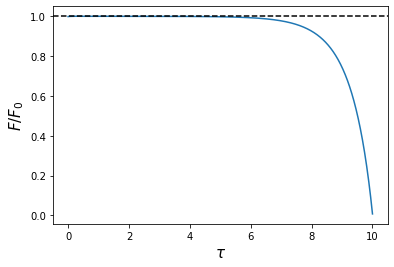

In [9]:
muvec = np.linspace(-1,1,50) 
jvec,hvec = [],[]
for mu in muvec:
    jvec.append(Solve(mu))
    hvec.append(h_from_j(jvec[-1],mu))
    
hvec = np.array(hvec)   # hvec is a 2D array (tau along rows, nu along columns)

Ftau=[]
for i in range(len(Tau)):
    hfunc = interp1d(muvec,hvec[:,i],kind='cubic')
    integrand = lambda mu: mu*hfunc(mu)
    y,_ = quad(integrand,0,1)
    Ftau.append(4*pi*y)
    
Ftau = 3/(4*np.pi) * np.array(Ftau)  # normalize
    
plt.figure()
plt.plot(Tau,Ftau)
plt.axhline(1,color='k',ls='--')
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$F/F_0$',fontsize=15)
# plt.ylim([0.98,1.02])
plt.show()

We recover our initial value for the flux except for at large optical depth where it goes to zero.  This is expected since the radiation becomes isotropic at large depths, hence the angle averaged intensity should go to zero.  You could redo this calculation with a maximum optical depth of 1000, and verify that the flux remains constant deeper in the atmosphere.

### Bonus
While we do expect $I_\nu\rightarrow B_\nu$ at large $\tau$, there must always be an anisotropic component to the intensity in order to carry energy outwards ($F~\sim\int_{-1}^{1}\mu I_\nu d\mu$ is always 0 if $I_\nu$ is isotropic). Therefore, our $h=0$ boundary condition is not correct. A more appropriate boundary condition is $dh/d\tau= 0$, which implies that this anisotropic component which creates the flux ($I(\mu)-I(-\mu)$) is constant deep in the atmosphere. We only have to change the last row of our matrix so that it is full of zeros except for the (N,N) component ($j_N=S_N$).

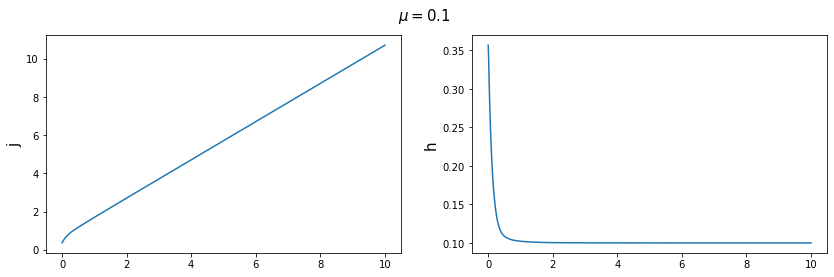

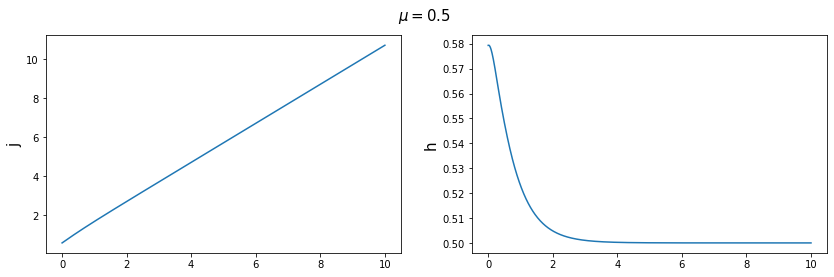

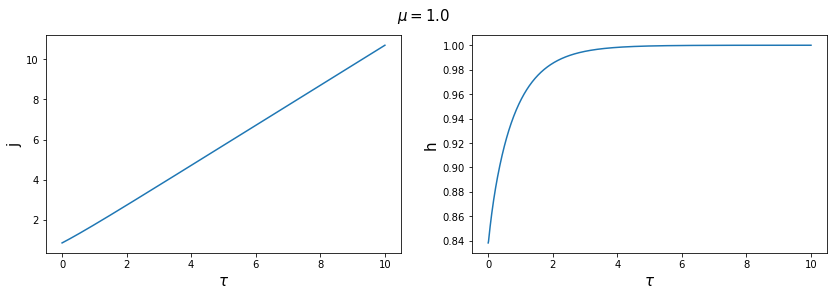

In [10]:
def Solve(mu):
    
    # Construct the Feautrier matrix then solve for j
    z = mu/dtau
    
    # The matrix is tri-diagonal
    bottom = [-z**2 for i in range(N-1)]
    top    = [-z**2 for i in range(N-1)]
    center = [(1+2*z**2) for i in range(N)]
    
    # tau=0 B.C.
    center[0] = 1+2*(z+z**2)
    top[0]    = -2*z**2
    
    # at tau->inf, dh/dtau=0, j=S
    center[-1] = 1
    bottom[-1] = 0 
    
    A = np.zeros((N,N))
    A[0][:2] = [center[0],top[0]]        # first line
    A[-1][-2:] = [bottom[-1],center[-1]] # last line
    for i in range(1,N-1):               # all other lines
        A[i][i-1:i+2] = [bottom[i-1],center[i],top[i]]
    
    return np.linalg.solve(A,S)

def h_from_j(j,mu):
    h=[j[0]]
    h[1:] = mu * (j[1:]-j[:-1])/dtau
    return h
        
# Test for three values of mu
for mu in [0.1,0.5,1]:
    j = Solve(mu)
    h = h_from_j(j,mu)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,4))
    fig.suptitle(r'$\mu=%.1f$'%mu,fontsize=15,fontweight='bold')
    ax1.plot(Tau,j)
    ax2.plot(Tau,h)
    ax1.set_ylabel('j',fontsize=15)
    ax2.set_ylabel('h',fontsize=15)
ax1.set_xlabel(r'$\tau$',fontsize=15)
ax2.set_xlabel(r'$\tau$',fontsize=15)
plt.show()

$h$ now stays constant at depth instead of dropping to zero.

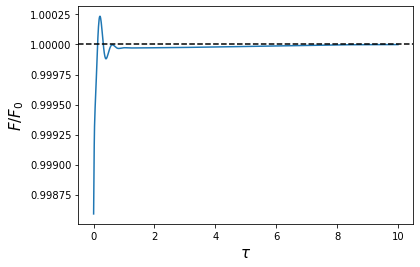

In [11]:
muvec = np.linspace(-1,1,50)
jvec,hvec = [],[]
for mu in muvec:
    jvec.append(Solve(mu))
    hvec.append(h_from_j(jvec[-1],mu))
    
hvec = np.array(hvec)

Ftau=[]
for i in range(len(Tau)):
    hfunc = interp1d(muvec,hvec[:,i],kind='cubic')
    integrand = lambda mu: mu*hfunc(mu)
    y,_ = quad(integrand,0,1)
    Ftau.append(4*pi*y)
    
Ftau = 3/(4*np.pi) * np.array(Ftau)  # normalize
    
plt.figure()
plt.plot(Tau,Ftau)
plt.axhline(1,color='k',ls='--')
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$F/F_0$',fontsize=15)
plt.show()

The flux has the right behavior at large depth. We do see some deviations because the plot is very zoomed in. Could we get rid of those..?